## **Setup & Load**

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
import os

sns.set_theme(style='whitegrid', palette='deep')
pd.options.display.float_format = "{:,.2f}".format

DATA_PATH = kagglehub.dataset_download("varishabatool/disorder")

Using Colab cache for faster access to the 'disorder' dataset.


In [55]:
df = pd.read_csv(os.path.join(DATA_PATH, "Sleep_health_and_lifestyle_dataset.csv"))

In [56]:
df

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.10,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.20,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.20,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.90,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.90,4,30,8,Obese,140/90,85,3000,Sleep Apnea
...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,370,Female,59,Nurse,8.10,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
370,371,Female,59,Nurse,8.00,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
371,372,Female,59,Nurse,8.10,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
372,373,Female,59,Nurse,8.10,9,75,3,Overweight,140/95,68,7000,Sleep Apnea


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


## **Exploratory Data Analysis**

In [58]:
eda_df = df.copy()

Checking for missing values and duplicates

In [59]:
missing = eda_df.isna().sum().sort_values(ascending=False)

pd.DataFrame({"Missing": missing, "Missing (%)": (missing / len(df) * 100)})

,Missing,Missing (%)
Sleep Disorder,219,58.56
Gender,0,0.00
Age,0,0.00
Occupation,0,0.00
Person ID,0,0.00
Sleep Duration,0,0.00
Quality of Sleep,0,0.00
Stress Level,0,0.00
Physical Activity Level,0,0.00
BMI Category,0,0.00


In [60]:
print(eda_df.duplicated().sum())

0


Simple feature engineering

In [61]:
bp_split = eda_df['Blood Pressure'].str.split('/', expand=True)

eda_df['Blood Pressure Systolic'] = pd.to_numeric(bp_split[0], errors='coerce')
eda_df['Blood Pressure Diastolic'] = pd.to_numeric(bp_split[1], errors='coerce')
eda_df.drop(columns=['Person ID', 'Blood Pressure'], inplace=True)

eda_df['Sleep Disorder'] = eda_df['Sleep Disorder'].fillna('No disorder')

In [62]:
numeric_features = eda_df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [feature for feature in numeric_features if feature not in ['Person ID']]
print(numeric_features)

['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps', 'Blood Pressure Systolic', 'Blood Pressure Diastolic']


In [63]:
categorical_features = eda_df.select_dtypes(include='O').columns.tolist()
categorical_features = [feature for feature in categorical_features if feature not in ['Sleep Disorder']]
print(categorical_features)

['Gender', 'Occupation', 'BMI Category']


Target variable distribution (Sleep Disorder)

In [64]:
counts = eda_df['Sleep Disorder'].value_counts().sort_values(ascending=False)

pd.DataFrame({"count": counts, "proportion (%)": (counts / len(df) * 100)})

,count,proportion (%)
Sleep Disorder,,
No disorder,219,58.56
Sleep Apnea,78,20.86
Insomnia,77,20.59


distribution of each categorical feature

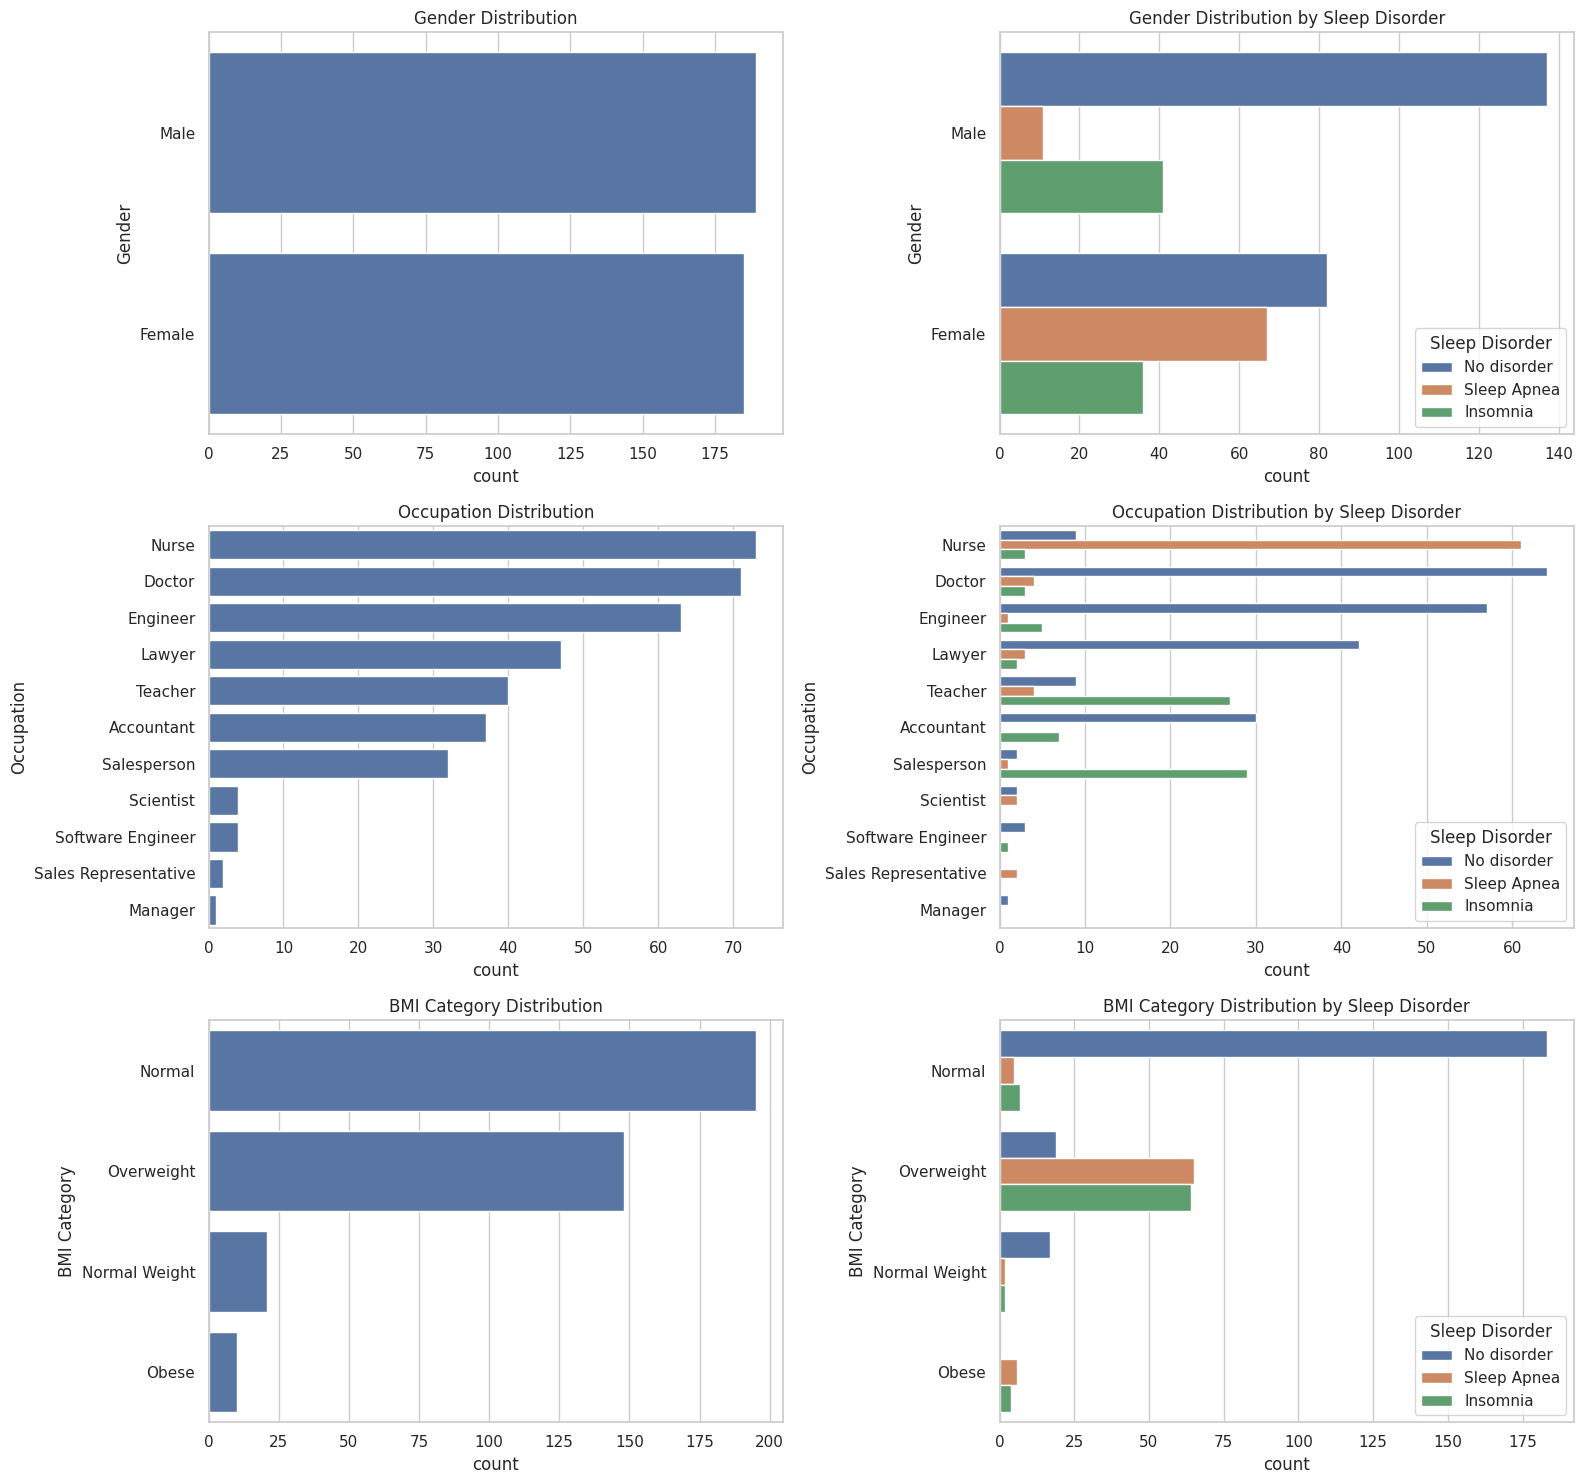

In [65]:
fig, axes = plt.subplots(len(categorical_features), 2, figsize=(16, 5 * len(categorical_features)))

for i, feature in enumerate(categorical_features):
    sns.countplot(data=eda_df, y=feature, order=eda_df[feature].value_counts().index, ax=axes[i, 0])
    axes[i, 0].set_title(f'{feature} Distribution')

    sns.countplot(data=eda_df, y=feature, hue='Sleep Disorder', order=eda_df[feature].value_counts().index, ax=axes[i, 1])
    axes[i, 1].set_title(f'{feature} Distribution by Sleep Disorder')

plt.tight_layout()
plt.show()

distribution of each numeric feature

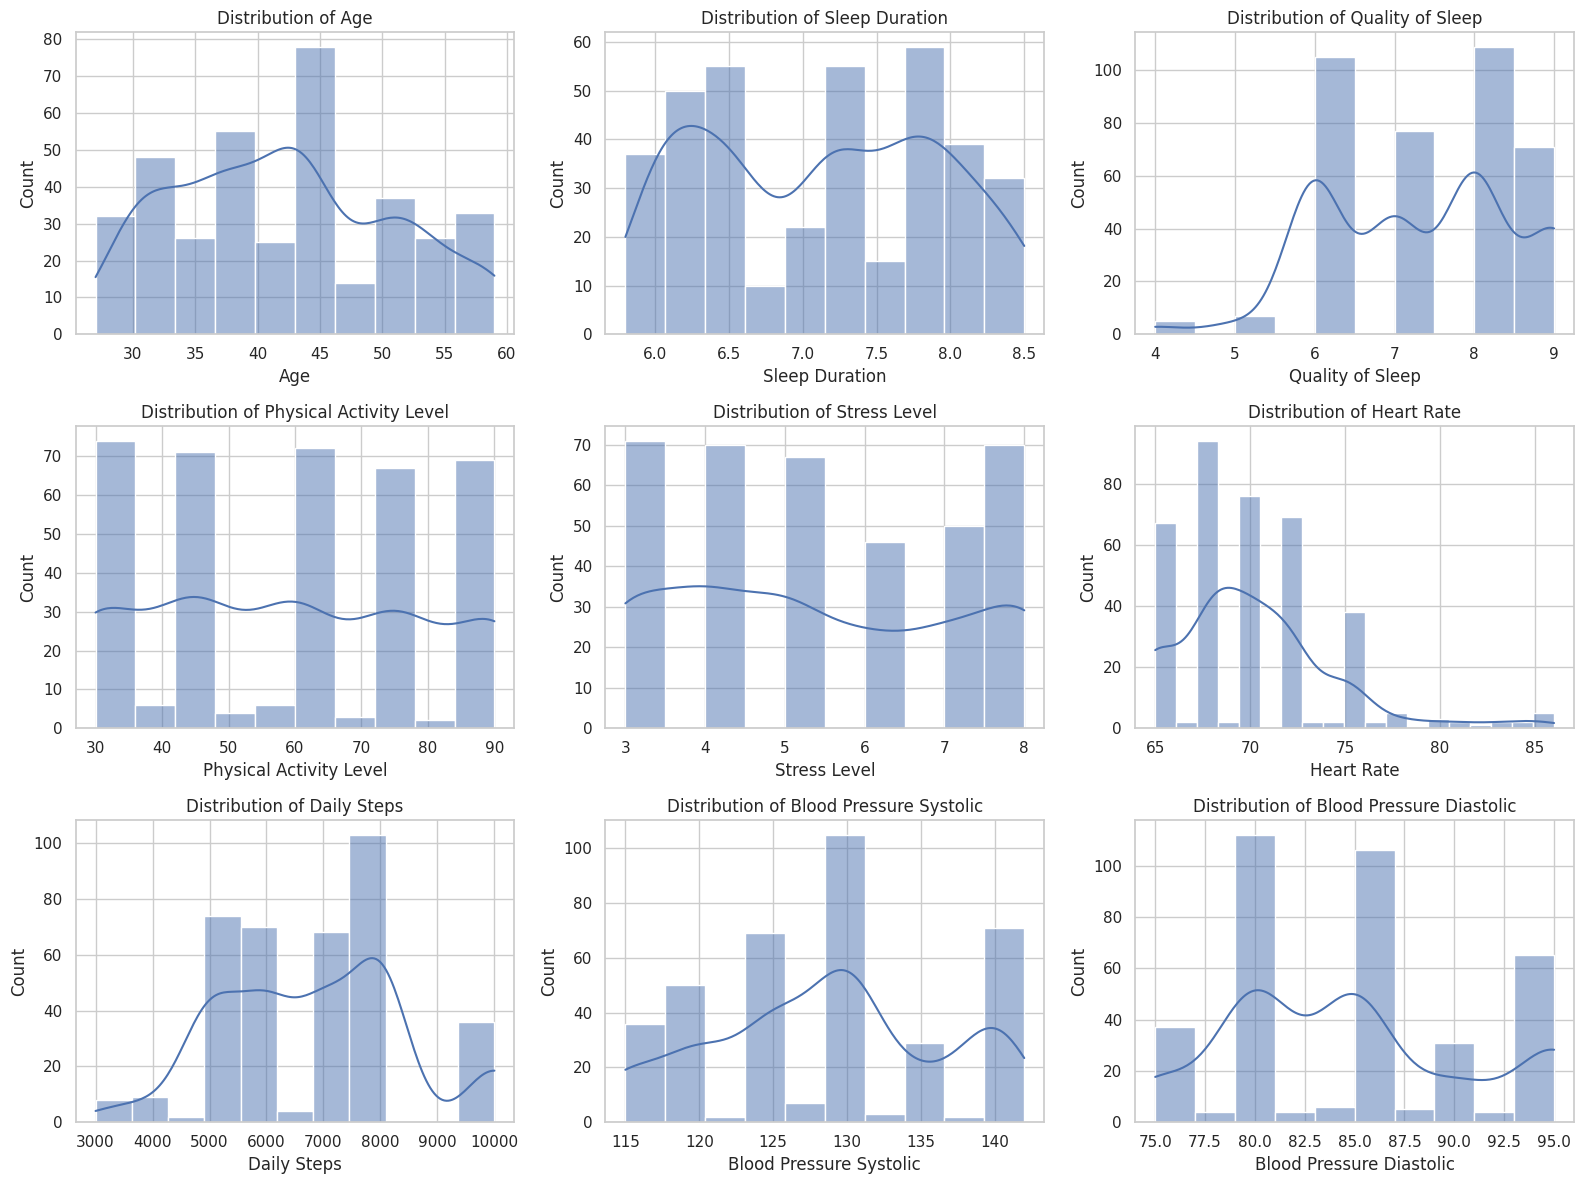

In [66]:
n_cols = 3
n_rows = int(np.ceil(len(numeric_features) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

for ax, feature in zip(axes, numeric_features):
    sns.histplot(data=eda_df[feature], bins='auto', kde=True, ax=ax)
    ax.set_title(f'Distribution of {feature}')

for ax in axes[len(numeric_features):]:
    ax.remove()

plt.tight_layout()
plt.show()

Correlation analysis

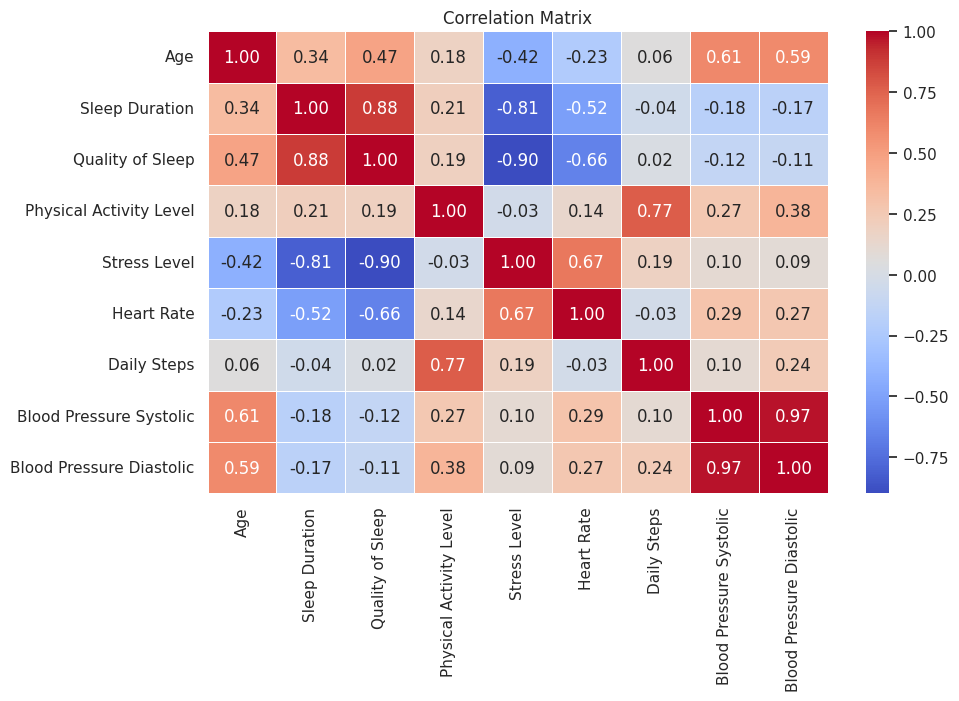

In [67]:
plt.figure(figsize=(10, 6))
corr = eda_df[numeric_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

Exclude features with strong correlation:

- Remove **Quality of Sleep**  
- Combine **Systolic Blood Pressure (SBP)** and **Diastolic Blood Pressure (DBP)** into a single feature — **Mean Arterial Pressure (MAP)**, calculated as:

$$MAP = \frac{SBP + 2 \times DBP}{3}$$

In [68]:
eda_df['MAP'] = ((eda_df['Blood Pressure Systolic'] + 2 * eda_df['Blood Pressure Diastolic']) / 3).round(2)
eda_df.drop(columns=['Quality of Sleep', 'Blood Pressure Systolic', 'Blood Pressure Diastolic'], inplace=True)

numeric_features = eda_df.select_dtypes(include=[np.number]).columns.tolist()

Pairwise feature plots colored by target

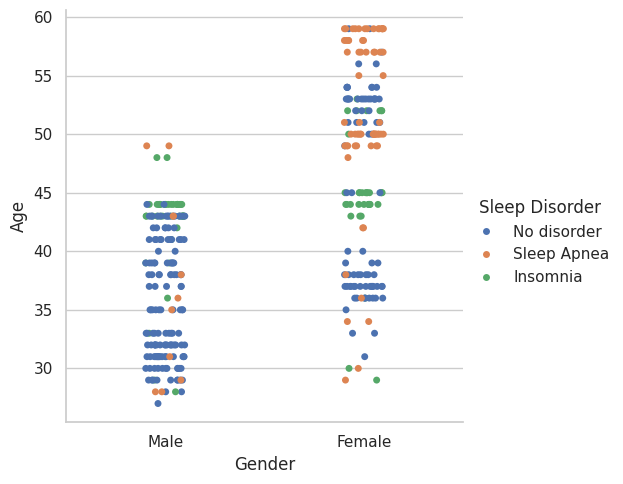

In [69]:
sns.catplot(data=eda_df, x='Gender', y='Age', hue='Sleep Disorder', height=5)
plt.show()

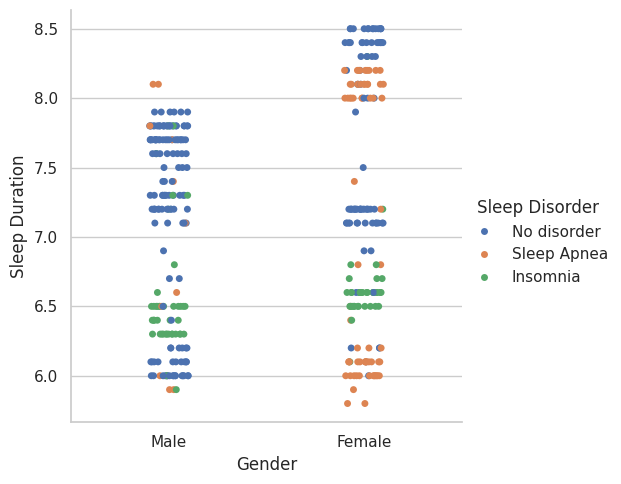

In [70]:
sns.catplot(data=eda_df, x='Gender', y='Sleep Duration', hue='Sleep Disorder', height=5)
plt.show()

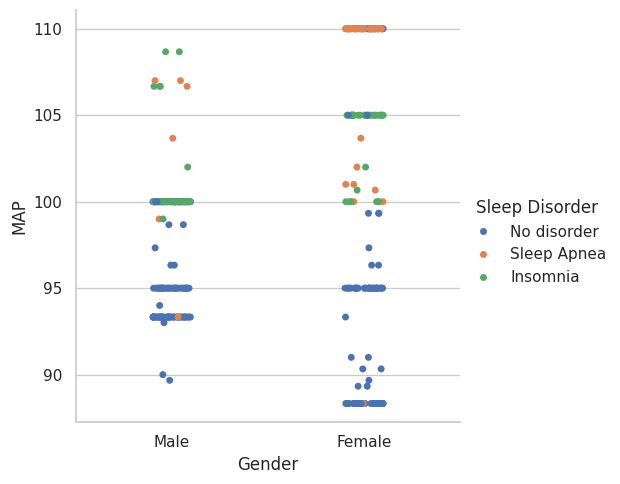

In [71]:
sns.catplot(data=eda_df, x='Gender', y='MAP', hue='Sleep Disorder', height=5)
plt.show()

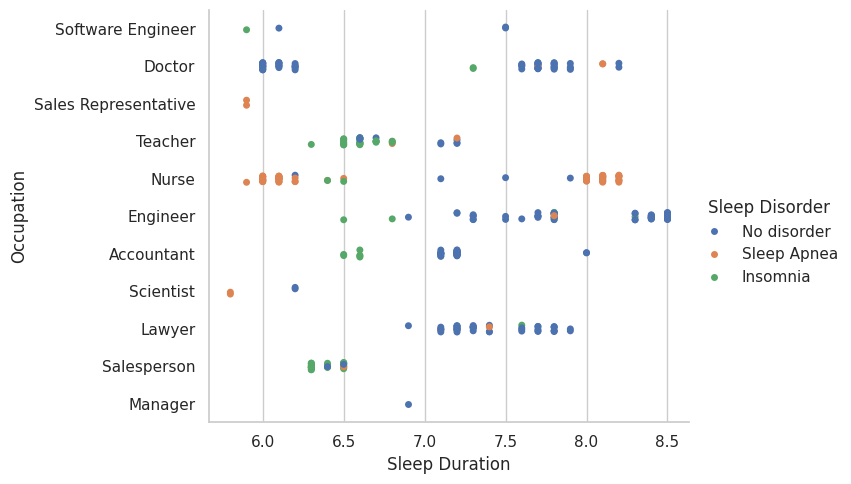

In [72]:
sns.catplot(data=eda_df, x='Sleep Duration', y='Occupation', hue='Sleep Disorder', height=5, aspect=1.5)
plt.show()

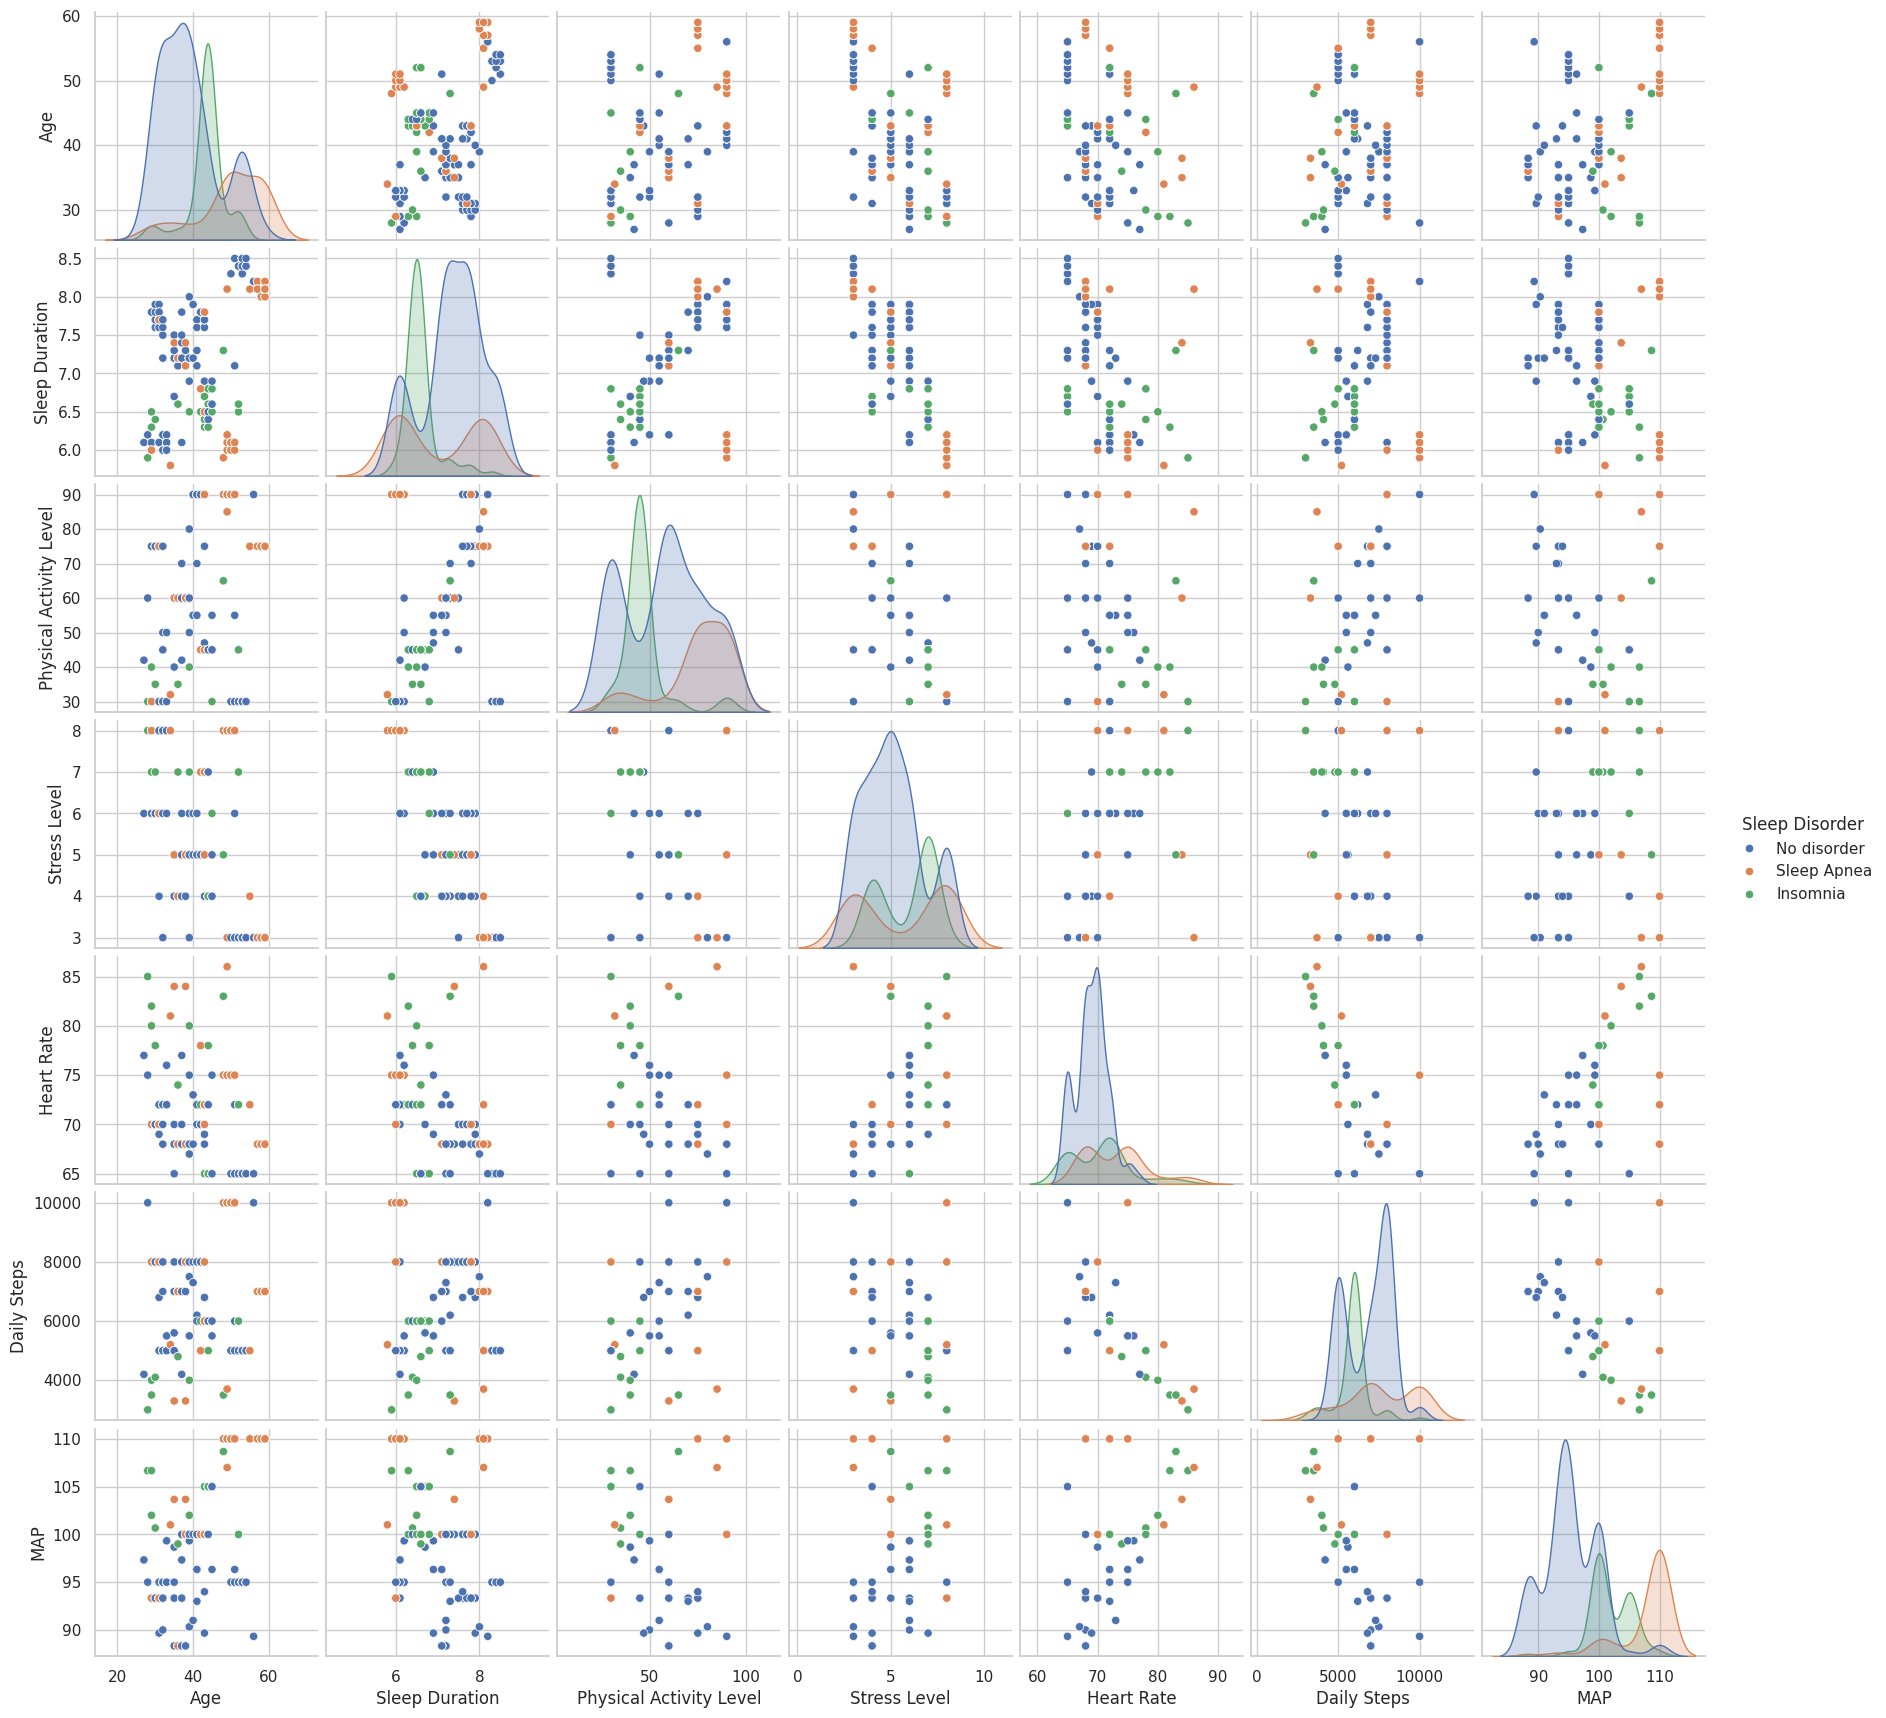

In [73]:
sns.pairplot(data=eda_df[numeric_features + ['Sleep Disorder']], hue='Sleep Disorder')
plt.show()

Boxplots of numerical features by target

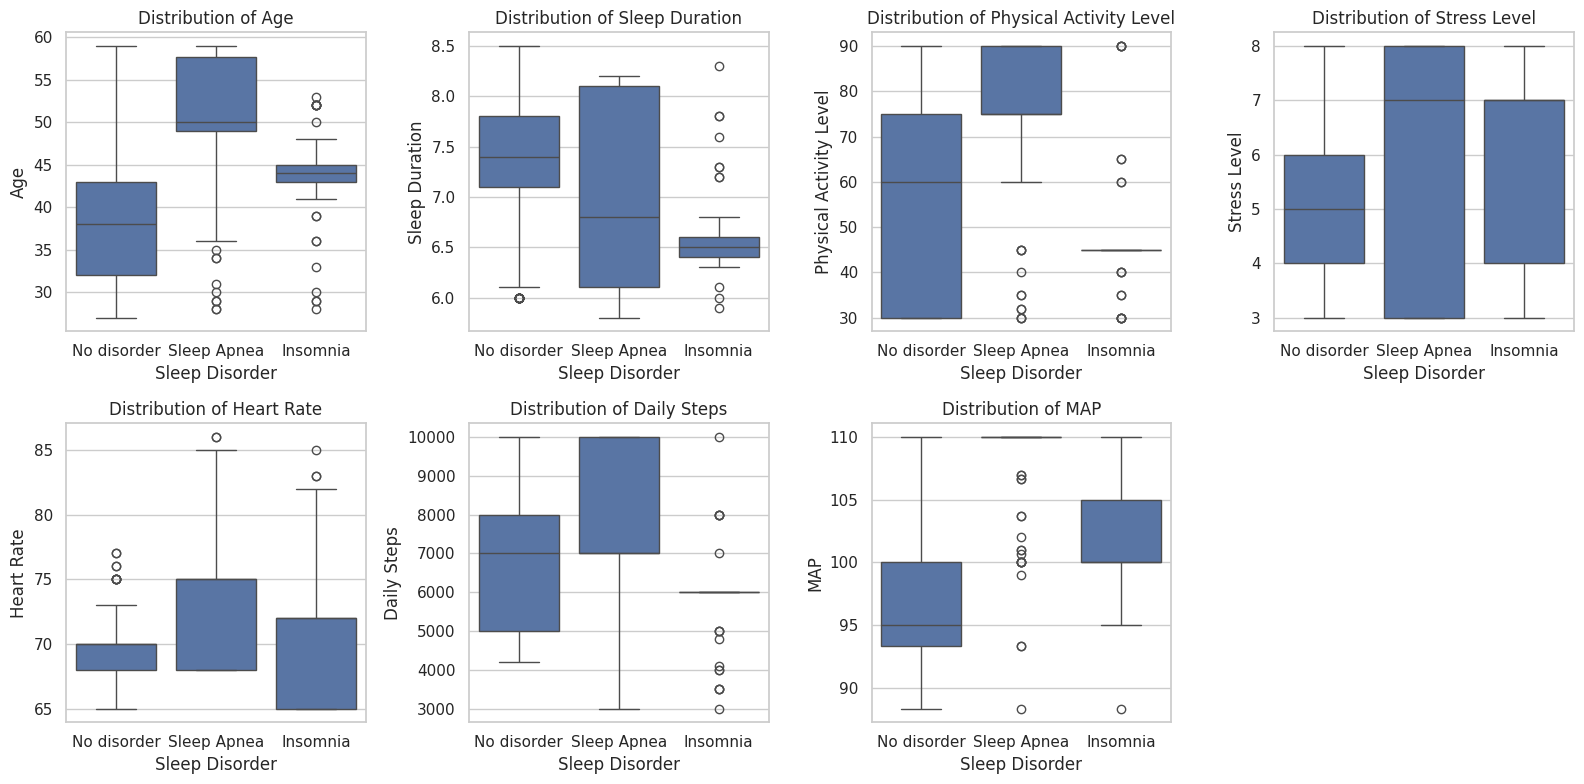

In [74]:
n_cols = 4
n_rows = int(np.ceil(len(numeric_features) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

for ax, feature in zip(axes, numeric_features):
    sns.boxplot(data=eda_df, x='Sleep Disorder', y=feature, ax=ax)
    ax.set_title(f'Distribution of {feature}')

for ax in axes[len(numeric_features):]:
    ax.remove()

plt.tight_layout()
plt.show()

## **Modeling**

In [75]:
# ! wget https://raw.githubusercontent.com/kasim-04/sleep-disorder-prediction/main/estimator_from_scratch.py

from estimator_from_scratch import MultiсlassLogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

In [76]:
model_df = eda_df.copy()

In [77]:
X = model_df[categorical_features + numeric_features]
y = model_df['Sleep Disorder']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [79]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', MultiсlassLogisticRegression(random_state=42))
])

param_grid = {
    'model__learning_rate': [0.001, 0.005, 0.01, 0.025, 0.05],
    'model__penalty': ['l1', 'l2'],
    'model__C': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

In [80]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'Sleep '
                                                                          'Duration',
                                                                          'Physical '
                                                                          'Activity '
                                                                          'Level',
                                                                          'Stress '
                                                                          'Level',
                                                                          'Heart '
                                                                          'Rate',
                                                                          'Daily '
                                                                          'Steps',
                                                                          'MAP']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Gender',
                                                                          'Occupation',
                                                                          'BMI '
                                                                          'Category'])])),
                                       ('model',
                                        MultiсlassLogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                         'model__learning_rate': [0.001, 0.005, 0.01, 0.025,
                                                  0.05],
                         'model__penalty': ['l1', 'l2']},
             scoring='f1_macro', verbose=2)

In [81]:
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая f1_macro:", grid_search.best_score_)

Лучшие параметры: {'model__C': 2.0, 'model__learning_rate': 0.01, 'model__penalty': 'l2'}
Лучшая f1_macro: 0.8611298899407493


report on train data

In [82]:
y_train_pred = grid_search.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

    Insomnia       0.78      0.85      0.81        54
 No disorder       0.93      0.93      0.93       153
 Sleep Apnea       0.90      0.80      0.84        54

    accuracy                           0.89       261
   macro avg       0.87      0.86      0.86       261
weighted avg       0.89      0.89      0.89       261



report on test data

In [83]:
y_test_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

    Insomnia       0.84      0.91      0.88        23
 No disorder       0.98      0.97      0.98        66
 Sleep Apnea       0.87      0.83      0.85        24

    accuracy                           0.93       113
   macro avg       0.90      0.91      0.90       113
weighted avg       0.93      0.93      0.93       113



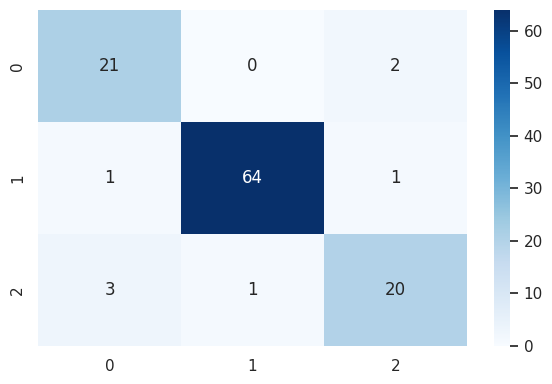

In [84]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.tight_layout()
plt.show()